# European Soccer Database


## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

As an average european male citizen I've always been interested in "football". In fact, I've done a fair bit of online football betting with not much success. It may well be that I was letting myself to passion as opposed to data. This project therefore represents a good opportunity to take more informed decissions should I decide to bet in the future.

The database is available at [Kaggle](https://www.kaggle.com/hugomathien/soccer). It consists of a sqlite database that contains eight different tables. The amount of detail in the database is overwhelming and for this project only a subset of the tables will be used. 

Before starting a discussion on what information is relevant for this project, let's first pose the questions and then discuss what parts of the database will be useful to answer them.
 > Since there is information on winning probability assigned by the bookmaker, it may be worth answering whether matches where there is a clear favourite show different statistics from those other matches where winning probabilities are more evenly distributed. **Does the fact that we know whether there is a favourite in a match increase our chances of predicting some other statistic about the game?**

 > It seems to me that the number of goals in any given stage will be directly related to how far into the season a match is played. At the beginning of the season there are generally some new players that have not adapted yet, also players are not yet in shape. At the end of the season players are generally tired after playing the whole season. So my question is **Are there more goals for stages that take place around mid-season?**

 > Also an 'a priori' thought that occurs to me is that when the probabilities for each result are not assigning a clear favourite, then to me (no data analysis yet...) that represent a totally random process where probabilities can be calculated with the information contained in the database. If for example the probability for home win was 40%. **Would an strategy of betting for home win when it pays > 1/0.4 be a successful strategy?**
 
 > Lastly, if I was the new president of an aspiring team with enough money. **Is it worth investing in a top10 scorer?** or in other words **Do top scorers play in the most successful teams**

In order to answer these questions above we then need the following tables from the database:
* **Country**. This table will enable comparing results by country name as opposed to country id
* **Match**. This table contains the bulk of data for this project and it will be used to answer every question
* **Player**. This table will help us answer last question
* **Team**. This table, again will help us answer last question and support some of the assertions in the analysis below   

I have deliverately not included the following tables

* **League**. The database only contains one league per country, so this table does not add any extra information
* **Player_Attributes**: This database contains information about player skill. This table does not add any information to answer the questions above.
* **Team_Attributes**: Similarly, this table does not add any useful information that could be used to answer the questions above.

The idea then is to query the database to extract all the useful information. Then doing all data wrangling process to have the data in the most organised way possible. To answer the first three questions, the **match** table contains most of the information required. However it will be seen that information from **Country** is also required.  

A list of the Python modules that will be used can be seen in the excerpt below.

In [164]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET
import random
%matplotlib inline

Also, worth mentioning that I've copied from [here](https://www.kaggle.com/jiezi2004/the-beautiful-game-1-data-preparation/notebook) the following two functions that will help me parse XML data.


In [12]:
def getTags(xMLcolumnNm, matches):
    elemList = []
    # iterate each row in the XML column
    for index, row in matches[pd.notnull(matches[xMLcolumnNm])].iterrows():
        # read in xml data
        tree = ET.ElementTree(ET.fromstring(row[xMLcolumnNm]))
        for elem in tree.iter():
            elemList.append(elem.tag) # append tag name

    # remove duplicates of tag names
    return list(set(elemList))
def parseXMLData(xMLcolumnNm, matches):
    tags = getTags(xMLcolumnNm,matches) # get a list of all tags
       
    tagLists = {} # host all other tags
    pos = []
    otherList = {'match_id':[], 'pos_x':[], 'pos_y':[]} # host match id
    
    for tag in tags:
        tagLists[tag] = [] # initiate tag lists   
        
    for index, row in matches[pd.notnull(matches[xMLcolumnNm])].iterrows():
        game_id = row['id'] # this helps identify match
        # rea-in XML data
        tree = ET.ElementTree(ET.fromstring(row[xMLcolumnNm]))
        root = tree.getroot()  
        
        for event in root.findall('value'):
            otherList['match_id'].append(game_id)
            for tag in tags:
                if(event.find(tag) is None):
                    tagLists[tag].append(None)
                else:
                    tagLists[tag].append(event.find(tag).text) 
                    
            # get position information
            if(event.find('coordinates') is None): 
                pos.append(None)
                pos.append(None)
            else:  
                for value in event.findall("coordinates/value"):
                    pos.append(value.text)
                    
    otherList['pos_y'] = pos[1::2]  # Elements from list1 starting from 1 iterating by 2
    otherList['pos_x'] = pos[0::2]  # Elements from list1 starting from 0 iterating by 2
            
    xmlInfo = {**otherList, **tagLists}
    return pd.DataFrame(xmlInfo)

Then, everything is ready to start getting data from the database. In order to fetch data we use the module sqlite3 that will help querying the data base with SQL grammar. Data from the database will be used to create pandas dataframes.

In [172]:
with sqlite3.connect('./database.sqlite') as con:
    df_countries = pd.read_sql_query("SELECT * from Country", con)
    df_matches = pd.read_sql_query("SELECT * from Match", con)
    df_teams = pd.read_sql_query("SELECT * from Team", con)
    df_players = pd.read_sql_query("SELECT player_api_id, player_name FROM Player;", con)

<a id='wrangling'></a>
## Data Wrangling

### General Properties

Now that all data is organised in dataframes, we are ready to start the data wrangling phase. The idea is to make changes to the original dataframes so that only relevant information is used. As explained in the introduction, the first three questions refer to general statistics about matches in general. Information on players or specific teams will not add relevant information. Therefore the main piece of data that I'll be using will be data contained in dataframe **df_matches**. Also, data will be more readable if the country appeared by name, as opposed to id. This means that a JOIN operation needs to be performed between df_matches and df_countries so all the information can be found under the same dataframe. The resulting dataframe will contain all information required to answer 3 out of our 4 questions, so **df_main** will be the name for this dataframe

### Operations on dataframes to obtain a clean *df_main*.

Data in df_countries is quite simple. It contains a mapping between country id and country name. For the purpose of this analysis only the three major (England, Italy and Spain) leagues will be chosen (Warning: Which are the major leagues it's a debatable topic, so this represents a personal opinion).  
 > * Filter df_countries to get only those countries I'm interested in.  

Once df_countries is ready, merge it with df_matches to form main_df. Please note, that the JOIN operation on these two dataframes will be an INNER JOIN. Therefore countries in df_matches that I'm not interested in, will be dropped after the JOIN operation.
 > * Perform an INNER JOIN  
 > * Rename the column id_y to id.

In [173]:
df_countries.query('name in ["England", "Italy", "Spain"]', inplace = True)
main_df = df_countries.merge(df_matches, left_on= 'id', right_on='country_id')
# Keep the id from matches, as we will need it for later JOINs
main_df.rename(columns={'id_y':'id'},inplace=True)
main_df.shape

(9097, 117)

It can be observed that our main dataframe contains a very large number of columns. After inspection it can be seen that there are many that can be pruned.  
For example it contains information about coordenates of players in the field. This does not bring any added benefit to this analysis. So let's remove those columns that contain coordinates. These are defined as home_playerX# home_playerY#, away_playerX# away_playerY#. Also individual footballers that played that game are of no interest so we can drop those as well. These ids are in the shape of home_player_#, away_player_#

There are still more columns we could get rid of... for example columns with betting odds. There are a number of 10 bookmakers in this dataframe, each of them using 3 columns for home, draw, away odds. It's understood that different betting companies will assign similar probabilities to the same sporting events. Let's quickly assert our understanding by comparing the average probabilities that different bookmakers have assinged to home win

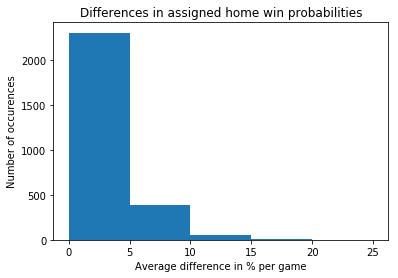

In [174]:
# Get a slice of the original dataframe containing only betting odds
bookies = df_matches.iloc[:,-10*3:]
bookies['homeWinSpread'] = np.repeat(0,len(bookies.index))
bookies.dropna(inplace=True) # In order to get spread bewtween bookies we don't care whether there are a few missing games
for bookieNum in range(1,10):
    # Compare probability deviations from the first bookmaker in the dataframe
    bookies['homeWinSpread'] += abs((bookies.iloc[:,3*bookieNum]/bookies.iloc[:,0]) - 1) 
bookies['homeWinSpread'] /= 0.09 # Divide by 9 to calculate average multiply by 100 to get percentage spread
plt.hist(bookies['homeWinSpread'],range(0,30,5));
plt.xlabel('Average difference in % per game');
plt.ylabel('Number of occurences');
plt.title('Differences in assigned home win probabilities');

It can be observed in the histogram above that probabilities assigned to home wins are on average *mostly* within 5% of each other. Therefore it's safe to get rid of all the bookmakers information BUT one

In [175]:
# id_x, league_id and country_id can be removed after the JOIN operation as they are no longer required.
redundantColumnList = ['id_x','league_id', 'country_id', 'match_api_id']
# Also, analysing information on players will be too time consuming, so player attributes or positions won't be explored
listToDrop = [('{}_player_{}{}'.format(side,coor,num),'{}_player_{}'.format(side,num) ) 
              for side in ['home','away'] for coor in ['X','Y'] for num in range(1,12)]
listToDrop = [x[0] for x in listToDrop ] + list(set([x[1] for x in listToDrop ])) + redundantColumnList
# Also, there are a total of 10 bookmakers... get only the first one
listToDrop = list(df_matches.columns[-9*3:]) + listToDrop
main_df.drop(columns=listToDrop, inplace =True)
main_df.info()
print ( "\n\nAre there any duplicate lines in this dataframe: {}".format(main_df.duplicated().any()))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9097 entries, 0 to 9096
Data columns (total 20 columns):
name                9097 non-null object
id                  9097 non-null int64
season              9097 non-null object
stage               9097 non-null int64
date                9097 non-null object
home_team_api_id    9097 non-null int64
away_team_api_id    9097 non-null int64
home_team_goal      9097 non-null int64
away_team_goal      9097 non-null int64
goal                9093 non-null object
shoton              9093 non-null object
shotoff             9093 non-null object
foulcommit          9093 non-null object
card                9093 non-null object
cross               9093 non-null object
corner              9093 non-null object
possession          9093 non-null object
B365H               9090 non-null float64
B365D               9090 non-null float64
B365A               9090 non-null float64
dtypes: float64(3), int64(6), object(11)
memory usage: 1.5+ MB


Are there a

From the information above we can see that there are no duplicated games, so that's good and nothing to do on that front.

However, there are matches that are missing data. Looking at the numbers it can be observed that the amount of missing information is small compared to the overall number of entries.

There are genearlly two ways to proceed with missing dat. We either make up the information or remove those rows. Since the number of lines with missing information is only a very small percentage of the whole, and also to ease analysis let's drop those rows.

Also, it seems that there are columns that are represented with the wrong type. For exmaple goal, foulcommit or card... This is because these columns contain more information in XML format. We will need to parse those columns, obtain new dataframes and remove these columns from our main dataframe since their information will be located somewhere else. Please note that data on *shot on, shot off* and *cross* is not relevant for our analysis and it won't be used

In [176]:
main_df.dropna(inplace=True)
goalInfo = parseXMLData('goal',main_df)
foulsInfo = parseXMLData('foulcommit',main_df)
cardsInfo = parseXMLData('card',main_df)
cornerInfo = parseXMLData('corner',main_df)
possessionInfo = parseXMLData('possession',main_df)
main_df.drop(columns=["goal","shoton","shotoff","foulcommit","card","cross","corner","possession"],inplace=True)
main_df.rename(columns={'home_team_api_id':'HT_id', 'away_team_api_id':'AT_id', 'home_team_goal':'HT_goal', 
                        'away_team_goal':'AT_goal'}, inplace=True)
main_df.head(1)

,name,id,season,stage,date,HT_id,AT_id,HT_goal,AT_goal,B365H,B365D,B365A
0,England,1729,2008/2009,1,2008-08-17 00:00:00,10260,10261,1,1,1.29,5.5,11.0


#### Data Wrangling on XML-formatted columns
The first line of our main_df dataframe displayed above shows the cleaning process results. Also the match above will be useful to verify whether the information parsed with the XML parser is trustworthy.

In [177]:
print (main_df[main_df['id'] == 1729].loc[:,['id','HT_id', 'AT_id']])
print ("\n\n")
print (df_teams.query('team_api_id in [10260,10261]'))
print ("\n\n")
print (df_players.query('player_api_id in [37799,38807,24148,24154]'))

     id  HT_id  AT_id
0  1729  10260  10261



      id  team_api_id       ...           team_long_name team_short_name
25  3457        10260       ...        Manchester United             MUN
26  3458        10261       ...         Newcastle United             NEW

[2 rows x 5 columns]



      player_api_id      player_name
2288          24148  Darren Fletcher
4592          38807     James Milner
8067          37799  Obafemi Martins
9333          24154       Ryan Giggs


According to results shown above this game was  
Manchester Ud. vs Newcastle Results 1-1 Players participating: Fletcher, Milner, Martins and Giggs
 
Let's check which of those values are important by looking at what happened in reality. Information can be found [here](
http://news.bbc.co.uk/sport1/hi/football/eng_prem/7551173.stm)

That link shows that only *player1* information is useful as it represents the scorer. Please note that player1 is represented by an ID. It will help readability to include the name instead of the ID. In order to do so, we will need to perform a JOIN operation between the goal dataframe (extracted from the XML info in matches table) and df_players. Also note that this new dataframe will help answer **question 4** so let's drop all other columns.  
The information that this dataframe contains (goalInfo) is already present in dF_main (just add home goals and away goals). However the cleaning operation on this dataframe will be useful to answer question 4. So we won't be looking at this dataframe for some time.

In [178]:
goalInfo = goalInfo[['match_id','player1']].dropna()
goalInfo['player1'] = goalInfo.player1.astype(int)
# Now add this information by doing a JOIN
goalInfo = goalInfo.merge(df_players,left_on='player1', right_on='player_api_id')
goalInfo.drop(columns='player1',inplace=True)
goalInfo.head(1)

,match_id,player_api_id,player_name
0,1729,37799,Obafemi Martins


The dataframe above contains lines that are duplicated so 
 > sum(goalInfo.duplicated()) != 0
 
 However this is most likely not a problem with the data itself... rather the most plausible explanation is that the same player scored twice in the same match

The next two XML-parsed dataframes that will be inspected are foulsInfo and cardsInfo. For these dataframes, we are only interested in the number of them per match. The caveat on cards, is that they can take three different values, that is 'y', 'y2' or 'r'. So let's start with fouls that look simpler and calculate the number of fouls per game. For cards let's group them first and see what the resulting dataframe looks like.

In [179]:
foulsInfo.drop(columns=[x for x in foulsInfo.columns if x not in ['match_id','id']],inplace=True)
foulsInfo = foulsInfo.groupby('match_id').count()
cardsInfo.drop(columns=[x for x in cardsInfo.columns if x not in ['match_id','card_type']],inplace=True)
cardsInfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42853 entries, 0 to 42852
Data columns (total 2 columns):
match_id     42853 non-null int64
card_type    42366 non-null object
dtypes: int64(1), object(1)
memory usage: 669.7+ KB


We can see that there are missing values of card_type in this dataframe. This time, we will follow a different approach, as I don't want to get rid of any game due to missing information on cards. Therefore calculate the probability of a card taking each value (y, y2,r), create a sample and use it to fill in those missing values.

Then prepare the resulting dataframe to be merged with main_df. It should result in three new columns in main_df one for each of the card types.

In [180]:
cardsByType = cardsInfo.groupby('card_type').count()
probRed = cardsByType.loc['r','match_id']/sum(cardsByType['match_id'])*100
probYellow = cardsByType.loc['y','match_id']/sum(cardsByType['match_id'])*100
probSecondYellow = cardsByType.loc['y2','match_id']/sum(cardsByType['match_id'])*100
# Based on the probabilities above, create a list with as many items as missing values in cards dataframe
cardTypeDummyList = [ 'y' if x > (probSecondYellow+probRed) else 'y2' 
                          if (x > probRed and x <= (probSecondYellow+probRed)) else 'r' for x in [random.randint(0,101) 
                          for _ in range(0, cardsInfo[cardsInfo['card_type'].isna()].count().match_id) ]]
# Fill the original dataframe with the random values calculated
cardsInfo.loc[cardsInfo['card_type'].isna(),'card_type'] = cardTypeDummyList
# Add a new column to count how many of each type
cardsInfo['helpColumn'] = np.repeat(1,len(cardsInfo.index))
cardstmp = cardsInfo.groupby(['match_id','card_type']).count()
# Use the previous information to create a dataframe where number of card type per match is used
# If there are missing values fill them with 0 as it means that no card of that type has been shonw
# for that game
cardsInfo = pd.DataFrame(index=cardstmp.unstack().index,columns=['y','y2','r'])
cardsInfo['y'] = cardstmp.unstack()['helpColumn','y'].fillna(0).astype(int)
cardsInfo['y2'] = cardstmp.unstack()['helpColumn','y2'].fillna(0).astype(int)
cardsInfo['r'] = cardstmp.unstack()['helpColumn','r'].fillna(0).astype(int)

For the last two XML-parsed dataframes... From corner get only the number of them in the game. From possession get the home and away possession percentages and prepare the dataframe to be merged to df_main

In [181]:
# From corners we may want to keep the following columns match_id, player1, team
cornerInfo.drop(columns=[x for x in cornerInfo.columns if x not in ['match_id','player1','team']],inplace=True)
cornerInfo = cornerInfo.groupby(['match_id']).count().drop(columns=['team'])
# From possession keep match_id, awaypos and drop all rows that don't contain possession infomration
possessionInfo.dropna(subset=['awaypos', 'homepos'],inplace=True)
possessionInfo.drop(columns=[x for x in possessionInfo.columns if x not in ['match_id','awaypos','homepos']],inplace=True)
# Since there are a few possession readings per game... and all seem similar, calculate the average per game
possessionInfo.awaypos = possessionInfo.awaypos.astype(float)
possessionInfo.homepos = possessionInfo.homepos.astype(float)
possessionInfo = possessionInfo.groupby('match_id').mean()

All the XML-parsed dataframes have now been processed and are ready to be incorporated to df_main. Perform all JOIN operations on these different dataframes

In [182]:
main_df = main_df.merge(foulsInfo,left_on='id',right_index=True).rename(columns={'id_y':'numFouls'}).drop(columns=['id_x'])
main_df = main_df.merge(cardsInfo,left_on='id',right_index=True,how='left')
main_df = main_df.merge(cornerInfo,left_on='id',right_index=True,how='left').rename(columns={'player1':'numCorners'})
main_df = main_df.merge(possessionInfo,left_on='id',right_index=True,how='left')
# Fill in NA positions with valid values
main_df.loc[main_df['awaypos'].isna(),'awaypos'] = 50
main_df.loc[main_df['homepos'].isna(),'homepos'] = 50
main_df.loc[main_df['numCorners'].isna(),'numCorners'] = 0
main_df.loc[main_df['y'].isna(),'y'] = 0
main_df.loc[main_df['y2'].isna(),'y2'] = 0
main_df.loc[main_df['r'].isna(),'r'] = 0
print(main_df.info())
main_df.head(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6220 entries, 0 to 9096
Data columns (total 19 columns):
id            6220 non-null int64
name          6220 non-null object
season        6220 non-null object
stage         6220 non-null int64
date          6220 non-null object
HT_id         6220 non-null int64
AT_id         6220 non-null int64
HT_goal       6220 non-null int64
AT_goal       6220 non-null int64
B365H         6220 non-null float64
B365D         6220 non-null float64
B365A         6220 non-null float64
numFouls      6220 non-null int64
y             6220 non-null float64
y2            6220 non-null float64
r             6220 non-null float64
numCorners    6220 non-null float64
awaypos       6220 non-null float64
homepos       6220 non-null float64
dtypes: float64(9), int64(7), object(3)
memory usage: 971.9+ KB
None


,id,name,season,stage,date,HT_id,AT_id,HT_goal,AT_goal,B365H,B365D,B365A,numFouls,y,y2,r,numCorners,awaypos,homepos
0,1729,England,2008/2009,1,2008-08-17 00:00:00,10260,10261,1,1,1.29,5.5,11.0,27,3.0,0.0,0.0,12.0,45.25,54.75


Let's summarize the steps taken to get all necessary dataframes that will help answer questions posed.
* Raw tables from the SQL database were obtained and parsed to dataframes
* Dataframes containing information on countries and matches were merged to form main_df
* After doing some cleaning and peeking at data types, it was noted that some columns contained more info in XML format
* These columns were in turn parsed to other dataframes containing info on goals, fouls, cards, corners and possession
* XML-parsed goals dataframe was merged with players table and will help answer question 4.
* The rest of XML-parsed dataframes were processed and merged back to main_df

We are then now ready to develop answers for the questions posed

<a id='eda'></a>
## Exploratory Data Analysis


<a id='conclusions'></a>
## Conclusions

